In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import math
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime 

# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
class Model(nn.Module):
    def __init__(self, n_classes):
        super(Model, self).__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

def check_valid_model(trainloader, model, device):
  ## test the model with 1 batch
  for images, labels in trainloader:
    images = images.to(device)
    _,out = model(images)
    print("batch size:", images.shape)
    print(out.shape)
    break

In [23]:
def load_data(BATCH_SIZE = 32):
    transform = transforms.Compose([transforms.Resize((32, 32)),transforms.ToTensor()])

    trainset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
    valset = datasets.MNIST(root='mnist_data', train=False, transform=transform)

    # define the data loaders
    trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
    valloader = DataLoader(dataset=valset, batch_size=BATCH_SIZE, shuffle=False)

    return trainset, valset, trainloader, valloader

In [24]:
def show_image(dataset, title, ROWS=5, COLUMNS=10):
    fig = plt.figure()
    for i in range(1, COLUMNS * ROWS + 1):
        plt.subplot(ROWS, COLUMNS, i)
        plt.axis('off')
        plt.imshow(dataset.data[i])
    fig.suptitle(title);

In [25]:
def get_accuracy(model, dataloader, device):
    correct = 0 
    total = 0
    with torch.no_grad():
        model.eval()
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            _, output = model(images)
            _, pred_labels = torch.max(output, 1)
            total += labels.size(0)
            correct += (pred_labels == labels).sum()
    return correct.float() / total

In [26]:
def train(trainloader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
    
        # Forward pass
        output, _ = model(images) 
        loss = criterion(output, labels) 
        running_loss += loss.item() * images.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    return model, optimizer, epoch_loss

In [27]:
def validate(valloader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output, _ = model(images) 
        loss = criterion(output, labels) 
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(valloader.dataset)
    return model, epoch_loss

In [28]:
def train_model(model, criterion, optimizer, trainloader, valloader, epochs, device, print_stride=1):
    best_loss = 1e10
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
 
    # Train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(trainloader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, val_loss = validate(valloader, model, criterion, device)
            val_losses.append(val_loss)

        if epoch % print_stride == (print_stride - 1):
            train_acc = get_accuracy(model, trainloader, device)
            val_acc = get_accuracy(model, valloader, device)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {val_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * val_acc:.2f}')
    
    return model, optimizer, (train_losses, val_losses), (train_accs, val_accs)

In [29]:
def plot_metric(train_metric, val_metric, metric):
    plt.style.use('seaborn')

    train_metric = np.array(train_metric) 
    val_metric = np.array(val_metric)

    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_metric, color='blue', label='Training '+metric) 
    ax.plot(val_metric, color='red', label='Validation '+metric)
    ax.set(title=metric+" over epochs", xlabel='Epoch', ylabel='Loss') 
    ax.legend()
    fig.show()
    
    plt.style.use('default')

In [70]:
def predict(model, image, device):
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        image = image.to(device)
        _, probs = model(image)
    
    return torch.argmax(probs)

In [58]:
def test_model(MODEL_NAME, model, valset, device, ROWS = 5, COLUMNS = 10):
    model = model.to(device)
    model.load_state_dict(torch.load(MODEL_NAME))

    fig = plt.figure()
    for i in range(1, COLUMNS * ROWS + 1):
        plt.subplot(ROWS, COLUMNS, i)
        plt.axis('off')
        plt.imshow(valset.data[i], cmap='gray_r')

        with torch.no_grad():
            model.eval()
            image = valset[i][0].unsqueeze(0)
            image = image.to(device)
            _, probs = model(image)

        title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
        plt.title(title, fontsize=7)
    fig.suptitle('Test predictions');

In [32]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NUM_EPOCHS = 15

# dataset properties
IMG_SIZE = 32
N_CLASSES = 10

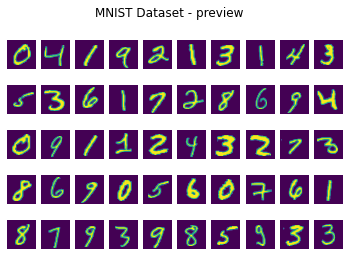

In [33]:
# Load and Display Data
trainset, valset, trainloader, valloader = load_data(BATCH_SIZE)
show_image(trainset, 'MNIST Dataset - preview')

In [34]:
# Defining Model and Functions
torch.manual_seed(RANDOM_SEED)
model = Model(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Check Model
check_valid_model(trainloader, model, device)

batch size: torch.Size([32, 1, 32, 32])
torch.Size([32, 10])


In [35]:
# Training Model
model, optimizer, losses, accs = train_model(model, criterion, optimizer, trainloader, valloader, NUM_EPOCHS, device)

19:45:18 --- Epoch: 0	Train loss: 0.2308	Valid loss: 0.0898	Train accuracy: 97.46	Valid accuracy: 97.29
19:45:39 --- Epoch: 1	Train loss: 0.0801	Valid loss: 0.0609	Train accuracy: 98.38	Valid accuracy: 98.25
19:46:00 --- Epoch: 2	Train loss: 0.0552	Valid loss: 0.0534	Train accuracy: 98.86	Valid accuracy: 98.35
19:46:21 --- Epoch: 3	Train loss: 0.0467	Valid loss: 0.0551	Train accuracy: 99.00	Valid accuracy: 98.30
19:46:42 --- Epoch: 4	Train loss: 0.0367	Valid loss: 0.0498	Train accuracy: 99.11	Valid accuracy: 98.53
19:47:03 --- Epoch: 5	Train loss: 0.0302	Valid loss: 0.0556	Train accuracy: 99.09	Valid accuracy: 98.42
19:47:24 --- Epoch: 6	Train loss: 0.0266	Valid loss: 0.0489	Train accuracy: 99.36	Valid accuracy: 98.47
19:47:46 --- Epoch: 7	Train loss: 0.0221	Valid loss: 0.0487	Train accuracy: 99.38	Valid accuracy: 98.52
19:48:07 --- Epoch: 8	Train loss: 0.0196	Valid loss: 0.0477	Train accuracy: 99.49	Valid accuracy: 98.56
19:48:28 --- Epoch: 9	Train loss: 0.0177	Valid loss: 0.0482	Trai

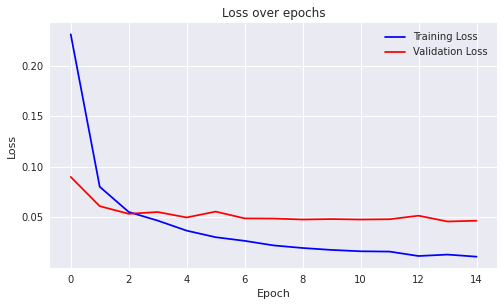

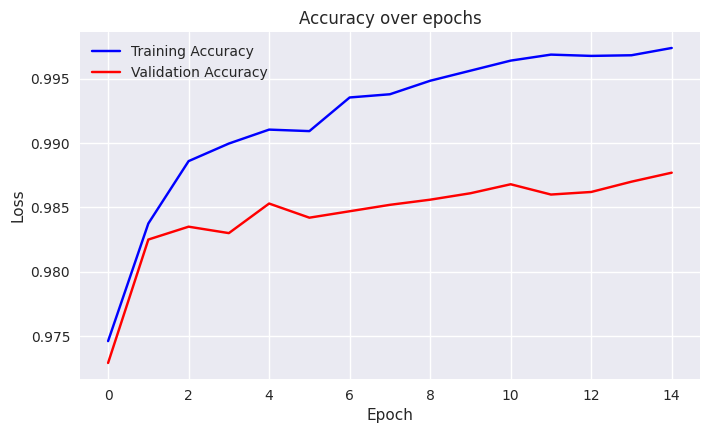

In [36]:
# Displaying Plots
plot_metric(losses[0], losses[1], 'Loss')
plot_metric(accs[0], accs[1], 'Accuracy')

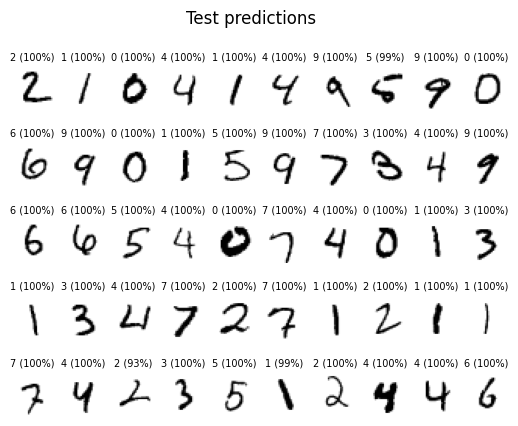

In [59]:
# Saving Model
MODEL_NAME = 'model.dth'
torch.save(model.state_dict(), MODEL_NAME)

# Test Model
test_model(MODEL_NAME, model, valset, device)

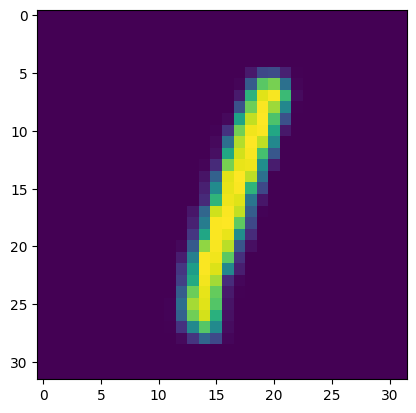

tensor(1, device='cuda:0')


In [76]:
# Predict Image
image = valset[5][0].unsqueeze(0)
pred = predict(model, image, device)
plt.imshow(image[0][0])
plt.show()
print(pred)